In [7]:
import multiprocessing

import cartopy.crs as ccrs
import cmaps
import tqdm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic

from matplotlib import pyplot as plt, gridspec
from matplotlib.ticker import MultipleLocator, FixedLocator, ScalarFormatter

from metpy.units import units
import metpy.calc as mpcalc
from metpy.xarray import grid_deltas_from_dataarray
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from toolbar.curved_quivers.modplot import Curlyquiver
from scipy.ndimage import filters

import xarray as xr
import xgrads as xg
import numpy as np

from toolbar.LBM.force_file import horizontal_profile as hp
from toolbar.LBM.force_file import vertical_profile as vp
from toolbar.LBM.force_file import mk_grads, mk_wave, interp3d_lbm
from toolbar.significance_test import corr_test

Interp LBM Waring: v is undefined.
Interp LBM Waring: d is undefined.
Interp LBM Waring: p is undefined.
Interp LBM Waring: v is undefined.
Interp LBM Waring: d is undefined.
Interp LBM Waring: p is undefined.


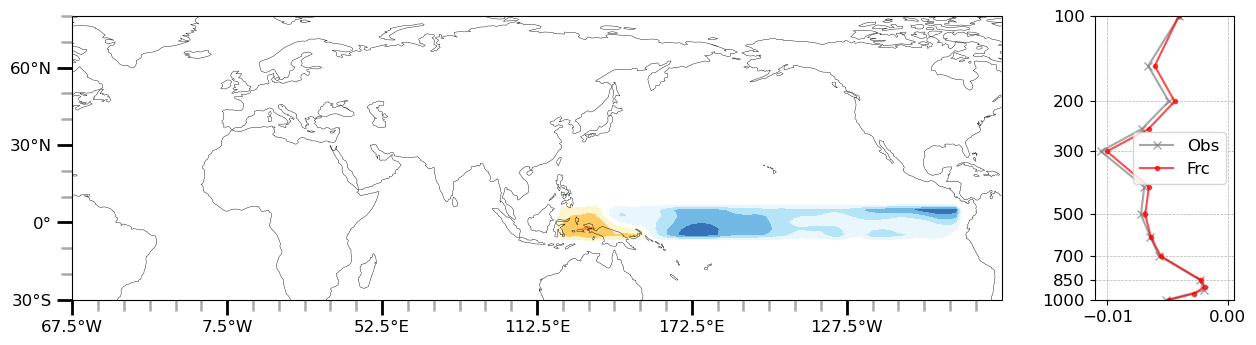

In [11]:
if __name__ == '__main__':
    info_t = xr.open_dataset(r"E:\data\self\q1_1961-2024.nc").sel(time=slice('1961-01-01', '2022-12-31'))
    info_t = info_t.sel(time=info_t['time.month'].isin([7, 8])).groupby('time.year').mean('time')
    ols = np.load(r"D:\PyFile\paper1\OLS35_detrended.npy")  # 读取缓存

    t1000 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q1000_same.npy")
    c1000 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q1000_same.npy") * t1000

    t925 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q925_same.npy")
    c925 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q925_same.npy") * t925

    t850 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q850_same.npy")
    c850 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q850_same.npy") * t850

    t700 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q700_same.npy")
    c700 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q700_same.npy") * t700

    t600 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q600_same.npy")
    c600 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q600_same.npy") * t600

    t500 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q500_same.npy")
    c500 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q500_same.npy") * t500

    t400 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q400_same.npy")
    c400 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q400_same.npy") * t400

    t300 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q300_same.npy")
    c300 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q300_same.npy") * t300

    t250 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q250_same.npy")
    c250 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q250_same.npy") * t250

    t200 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q200_same.npy")
    c200 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q200_same.npy") * t200

    t150 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q150_same.npy")
    c150 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q150_same.npy") * t150

    t100 = np.load(r"D:\PyFile\paper1\cache\q1\reg_q100_same.npy")
    c100 = np.load(r"D:\PyFile\paper1\cache\q1\corr_q100_same.npy") * t100

    pre = np.load(r"D:\PyFile\paper1\cache\pre\corr_pre_same.npy")
    pre_lon = xr.open_dataset(r"E:\data\NOAA\PREC\precip.mon.anom.nc").lon
    pre_lat = xr.open_dataset(r"E:\data\NOAA\PREC\precip.mon.anom.nc").lat
    t_lon = xr.open_dataset(r"E:\data\self\q1_1961-2024.nc").lon
    t_lat = xr.open_dataset(r"E:\data\self\q1_1961-2024.nc").lat
    # 将pre双线性插值到t网格
    pre = xr.DataArray(pre, coords=[('lat', pre_lat.data), ('lon', pre_lon.data)])
    pre = pre.interp(lat=t_lat.data, lon=t_lon.data, method='linear')
    frc = xr.Dataset({'t':(['lev', 'lat', 'lon'],
                           np.array([c1000, c925, c850, c700, c600, c500, c400, c300, c250, c200, c150, c100]) * pre.data)},
                     coords={'lev': [1000, 925, 850, 700, 600, 500, 400, 300, 250, 200, 150, 100],
                             'lat': info_t['lat'],
                             'lon': info_t['lon']})
    # 读取强迫场
    # 选择45-90N，35W-35E的区域

    T = frc * units('K')
    lon, lat = np.meshgrid(frc['lon'], frc['lat'])
    mask = (
            (np.where(lon<= 275.0, 1, 0) * np.where(lon>= 122.00, 1, 0))
            * (np.where(lat>= -5.00, 1, 0) * np.where(lat<= 5.00, 1, 0))
            )

    T_mask = T.where(mask != 0, 0)

    frc_nc_sigma = interp3d_lbm(T_mask)
    frc_nc_p = interp3d_lbm(T_mask, 'p')
    # 绘图
    # 图1
    var = 't' #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    lev = 500
    n = 10
    extent1 = [-180, 180, -30, 80]
    fig = plt.figure(figsize=(10, 5), constrained_layout=True)
    ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180-67.5))
    ax1.coastlines(linewidths=0.3)
    ax1.set_extent(extent1, crs=ccrs.PlateCarree())

    prelon, prelat = np.meshgrid(pre['lon'], pre['lat'])
    premask = (
            (np.where(prelon<= 275.0, 1, 0) * np.where(prelon>= 122.00, 1, 0))
            * (np.where(prelat>= -5.00, 1, 0) * np.where(prelat<= 5.00, 1, 0))
            )
    pre_mask = pre.where(premask != 0, 0)
    frc_fill_white, lon_fill_white = add_cyclic(pre_mask, pre_mask['lon'])
    lev_range = np.linspace(-np.nanmax(np.abs(pre_mask.data)), np.nanmax(np.abs(pre_mask.data)), 10)
    var200 = ax1.contourf(lon_fill_white, pre_mask['lat'], frc_fill_white,
                        levels=lev_range, cmap=cmaps.BlueWhiteOrangeRed[20:-20], transform=ccrs.PlateCarree(central_longitude=0), extend='both')
    # 刻度线设置
    xticks1 = np.arange(extent1[0], extent1[1] + 1, 10)
    yticks1 = np.arange(extent1[2], extent1[3] + 1, 10)
    lon_formatter = LongitudeFormatter()
    lat_formatter = LatitudeFormatter()
    # ax1
    ax1.set_xticks(xticks1, crs=ccrs.PlateCarree())
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.set_yticks(yticks1, crs=ccrs.PlateCarree())
    ax1.yaxis.set_major_formatter(lat_formatter)

    xmajorLocator = MultipleLocator(60)  # 先定义xmajorLocator，再进行调用
    xminorLocator = MultipleLocator(10)
    ymajorLocator = MultipleLocator(30)
    yminorLocator = MultipleLocator(10)

    ax1.yaxis.set_major_locator(ymajorLocator)  # y轴最大刻度
    ax1.yaxis.set_minor_locator(yminorLocator)  # y轴最小刻度
    ax1.xaxis.set_major_locator(xmajorLocator)  # x轴最大刻度
    ax1.xaxis.set_minor_locator(xminorLocator)  # x轴最小刻度
    # ax1.axes.xaxis.set_ticklabels([]) ##隐藏刻度标签
    # 最大刻度、最小刻度的刻度线长短，粗细设置
    ax1.tick_params(which='major', length=11, width=2, color='darkgray')  # 最大刻度长度，宽度设置，
    ax1.tick_params(which='minor', length=8, width=1.8, color='darkgray')  # 最小刻度长度，宽度设置
    ax1.tick_params(which='both', bottom=True, top=False, left=True, labelbottom=True, labeltop=False)
    plt.rcParams['xtick.direction'] = 'out'  # 将x轴的刻度线方向设置向内或者外
    # 调整刻度值字体大小
    ax1.tick_params(axis='both', labelsize=12, colors='black')
    # ax2 垂直层结
    ax_ins = inset_axes(
        ax1,
        width="15%",  # width: 5% of parent_bbox width
        height="100%",  # height: 50%
        loc="lower left",
        bbox_to_anchor=(1.1, 0., 1, 1),
        bbox_transform=ax1.transAxes,
        borderpad=0,
    )

    ax2 = ax_ins
    S2D = 86400.
    # 计算各层平均温度
    avg_temp = T_mask['t'].sel(lon=slice(180, 275), lat=slice(5, -5)).mean(dim=['lat', 'lon']).values.squeeze()  # 按纬度和经度平均
    avg_temp_frc_nc_np = frc_nc_p['t'].sel(lon=slice(180, 275), lat=slice(5, -5)).mean(dim=['lat', 'lon']).values.squeeze() * S2D  # frc_nc_p 各层平均温度
    pressure_levels = frc['lev'].values  # 气压层次
    pressure_levels_frc_nc_np = frc_nc_p['lev'].values  # frc_nc_p 的气压层次

    # 在 ax2 上绘制
    ax2.plot(avg_temp, pressure_levels, marker='x', color='gray', label='Obs', alpha=0.7)
    ax2.plot(avg_temp_frc_nc_np, pressure_levels_frc_nc_np, marker='.', color='r', label='Frc', alpha=0.7)

    # 设置横纵坐标范围
    ax2.set_ylim(100, 1000)  # 设置纵轴范围
    #ax2.set_xlim(-.001, 0.004)  # 设置横轴范围
    # 设置纵轴为反转的气压坐标
    ax2.set_yscale('log')  # 气压通常采用对数坐标
    ax2.invert_yaxis()  # 倒置 y 轴，使高压在下，低压在上

    # 设置坐标轴标签和标题
    #ax2.set_xlabel('T/K', fontsize=14)
    #ax2.set_ylabel('P/hPa', fontsize=14)

    # 设置刻度和网格
    ax2.yaxis.set_major_locator(FixedLocator([1000, 850, 700, 500, 300, 200, 100]))  # 使用线性刻度标注
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax2.yaxis.set_minor_locator(FixedLocator([]))  # 设置次要刻度线
    ax2.yaxis.set_minor_formatter(ScalarFormatter())
    ax2.grid(which='both', linestyle='--', linewidth=0.5)
    ax2.tick_params(axis='both', which='major', labelsize=12)

    # 添加图例
    ax2.legend(fontsize=12)
    plt.show()